# Machine Learning project

### Dataset: Bikesharing data from London for 4 years. 
Predicting the demand for bikes based on time, day and weather conditions

In [113]:
import kagglehub
import os
import matplotlib.pyplot as plt
import missingno as msno  
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
import itertools
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.base import BaseEstimator, TransformerMixin
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import validation_curve

In [114]:
# Download the dataset
path = kagglehub.dataset_download("hmavrodiev/london-bike-sharing-dataset")
print("Path to dataset files:", path)

# Load the dataset
df = pd.read_csv(os.path.join(path, "london_merged.csv"))

# Display the first few rows of the dataset
print(df.head())

Path to dataset files: C:\Users\ARSENIY_\.cache\kagglehub\datasets\hmavrodiev\london-bike-sharing-dataset\versions\1
             timestamp  cnt   t1   t2    hum  wind_speed  weather_code  \
0  2015-01-04 00:00:00  182  3.0  2.0   93.0         6.0           3.0   
1  2015-01-04 01:00:00  138  3.0  2.5   93.0         5.0           1.0   
2  2015-01-04 02:00:00  134  2.5  2.5   96.5         0.0           1.0   
3  2015-01-04 03:00:00   72  2.0  2.0  100.0         0.0           1.0   
4  2015-01-04 04:00:00   47  2.0  0.0   93.0         6.5           1.0   

   is_holiday  is_weekend  season  
0         0.0         1.0     3.0  
1         0.0         1.0     3.0  
2         0.0         1.0     3.0  
3         0.0         1.0     3.0  
4         0.0         1.0     3.0  


# Visual Analysis of Dataset:

Initially I wanted to analyze the dataset graphically, so it would be more meaningful to me. I chose this dataset because I belive application of the machine learning in this scenario is going to be beneficial for bikesharing, as they would be able to adjust for demand of the scooters in advance, just by knowing day(what kind of the day it is) , time and weather. 

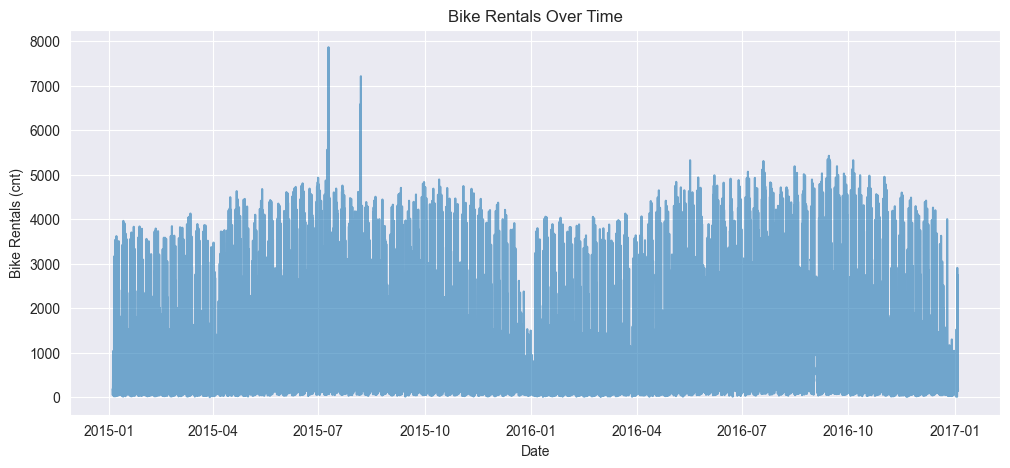

In [115]:
#Convert the timestamp into meaningful data
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['cnt'], alpha=0.6)
plt.xlabel("Date")
plt.ylabel("Bike Rentals (cnt)")
plt.title("Bike Rentals Over Time")
plt.show()


We see that dataset is mostly 

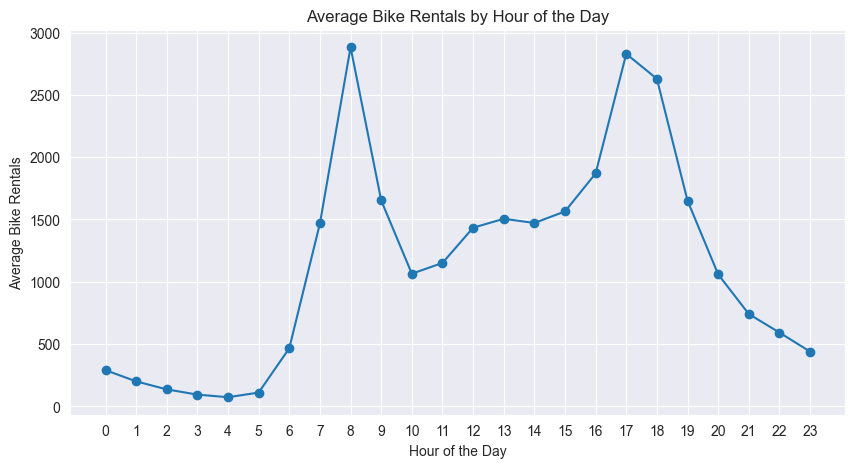

In [116]:
hourly_avg = df.groupby('hour')['cnt'].mean()
plt.figure(figsize=(10, 5))
plt.plot(hourly_avg.index, hourly_avg.values, marker='o')
plt.xlabel("Hour of the Day")
plt.ylabel("Average Bike Rentals")
plt.title("Average Bike Rentals by Hour of the Day")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

From this picture we see that we have two main peaks for bike demand, during the morning (assuming that people go to work, uni etc) and from 17-18, showing that some people use biks to return home as well. This helps us to understand how the mean demand is influenced by the time of the day

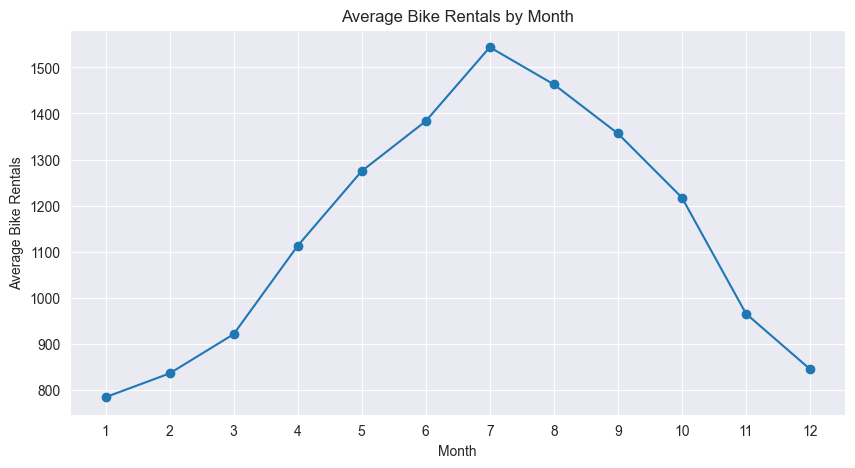

In [117]:
monthly_avg = df.groupby('month')['cnt'].mean()
plt.figure(figsize=(10, 5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-')
plt.xlabel("Month")
plt.ylabel("Average Bike Rentals")
plt.title("Average Bike Rentals by Month")
plt.xticks(range(1, 13))
plt.grid(True)
plt.show()

We can see that most of the bikesharing happens in summer, with a quite a big decrease in the winter months, and with medium demand during the fall and spring.  

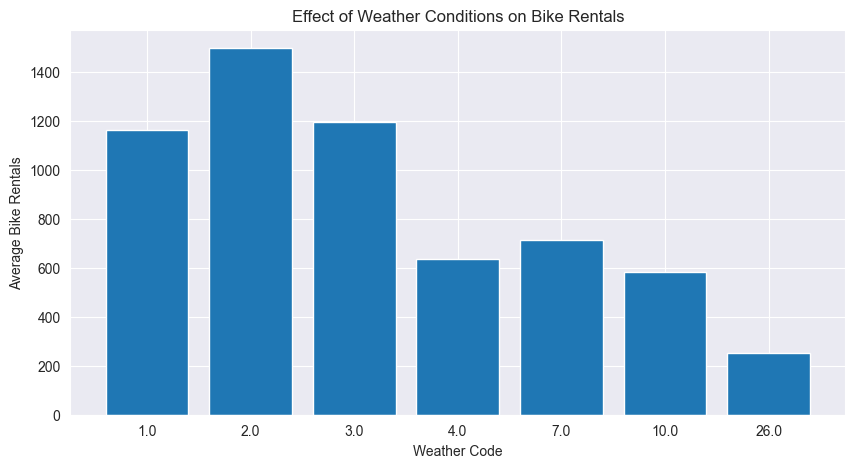

In [118]:
# Compute average bike rentals per weather code
weather_avg = df.groupby('weather_code')['cnt'].mean()

# Create a new index for continuous spacing
x_positions = range(len(weather_avg))  # Sequential positions for bars

plt.figure(figsize=(10, 5))
plt.bar(x_positions, weather_avg.values)  # Use sequential positions
plt.xlabel("Weather Code")
plt.ylabel("Average Bike Rentals")
plt.title("Effect of Weather Conditions on Bike Rentals")

# Replace x-axis labels with the actual weather codes
plt.xticks(x_positions, weather_avg.index, rotation=0)  

plt.show()

And finally, here we can see a decreasing trend, where the weather code is indicating the severity of the weather, the higher it is, the severe the weather is. So when the weather is severe, less people are going to use bikesharing for obvious reasons.

# Preprocessing of dataset

In [119]:
np.random.seed(42)
n_missing = int(0.02 * len(df))
for col in df.columns:
    if col != 'timestamp' and col != 'cnt':  # skip timestamp column
        n_missing = int(0.02 * len(df))
        missing_indices = np.random.choice(df.index, n_missing, replace=False)
        df.loc[missing_indices, col] = np.nan

Count how many missing values are added, target 2% of the dataset. 

In [120]:

print("\nAfter introducing missing values:")
print(df.isna().sum())



After introducing missing values:
timestamp         0
cnt               0
t1              348
t2              348
hum             348
wind_speed      348
weather_code    348
is_holiday      348
is_weekend      348
season          348
hour            348
day_of_week     348
month           348
dtype: int64


Visualizing the missing data to ensure that it is taken from different points of dataset and that it is not biased in any way

<Axes: >

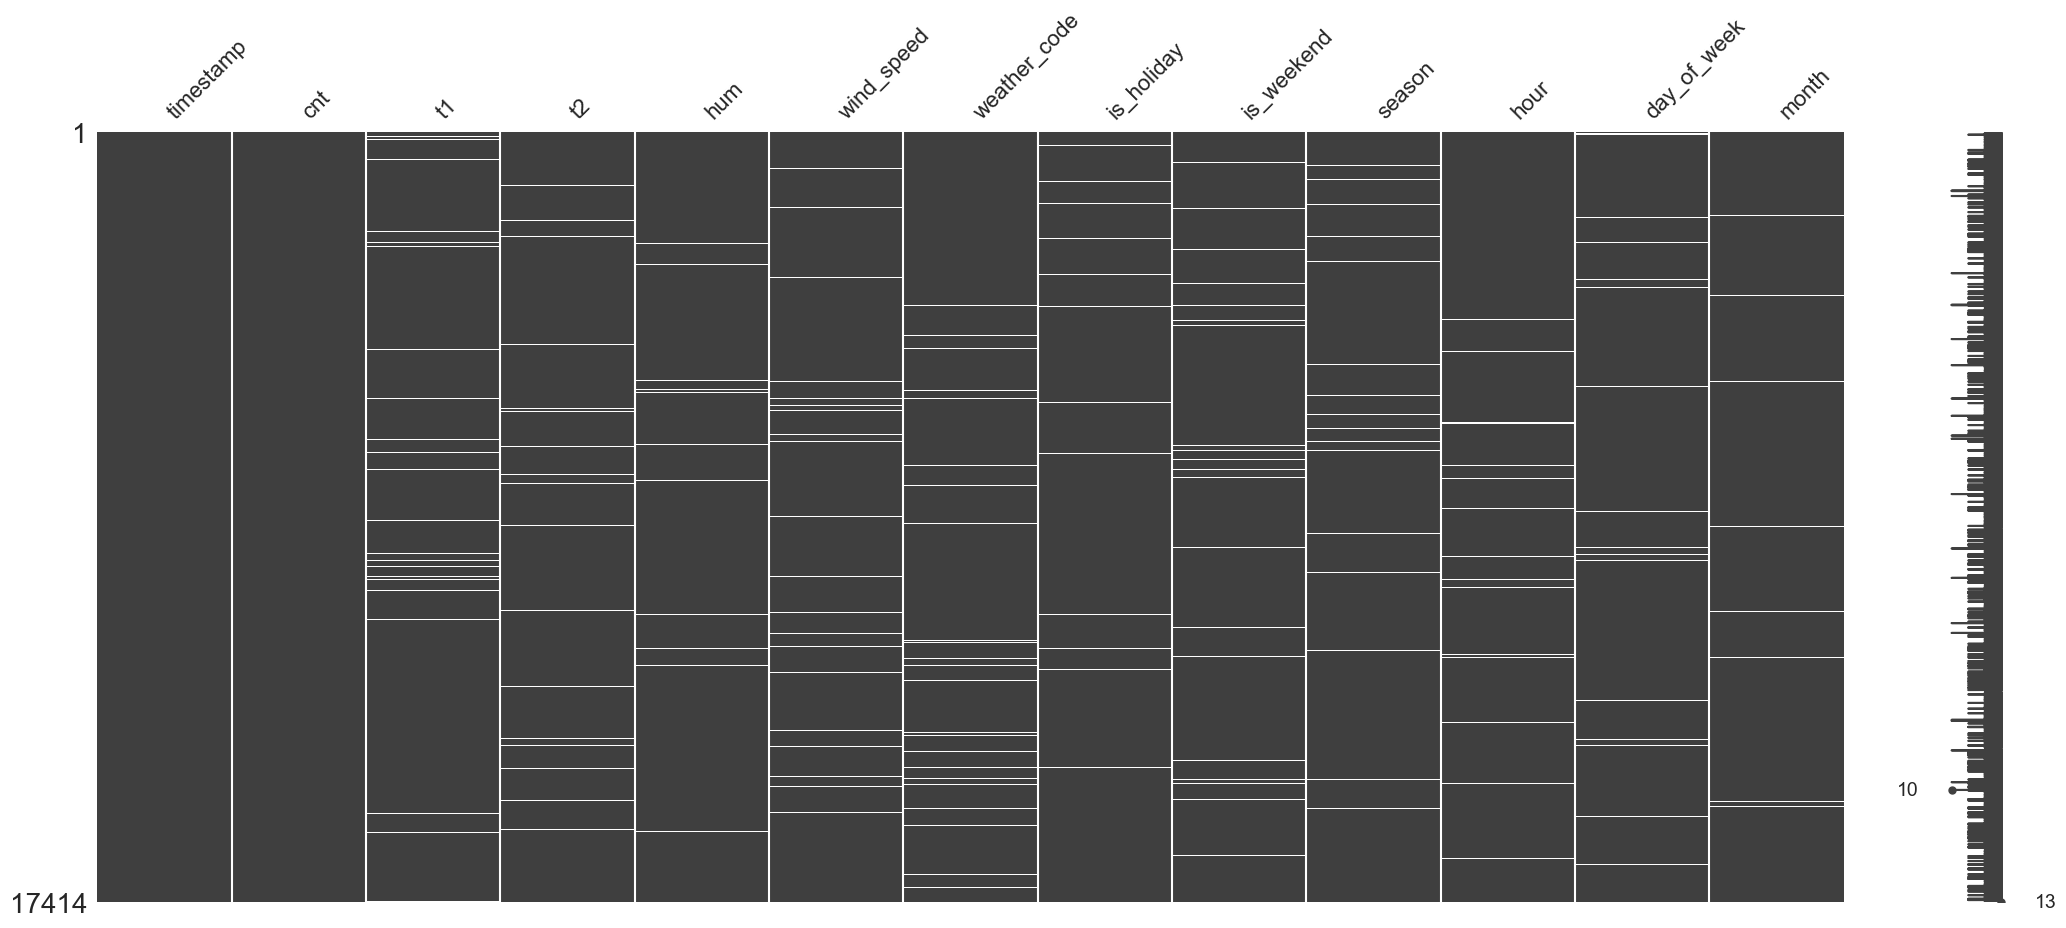

In [121]:
msno.matrix(df)

# Preprocessing

As you can see, the weather codes is given by different values, where some of them like 26 and 10 are not close to each other, however this difference is not correspoding to the actual increase in the severity of the weather, so that I decided to standardize this column to just 4 unique values from 1 to 4. 

In [122]:
df["weather_code"].unique()

array([ 3.,  1.,  4., nan,  7.,  2., 26., 10.])

As it is given from the description of the dataset, the values here correspond to different conditions

1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 2 = scattered clouds / few clouds 3 = Broken clouds 4 = Cloudy 7 = Rain/ light Rain shower/ Light rain 10 = rain with thunderstorm 26 = snowfall

From that infromation, we are going to separate the weather codes into 3 distinct, where 1 = clear\small fog\ few clouds 2 = broken clouds\cloddy and 3 = rain, 4 = rain+thundershorm and snowfall

Adding a custom transformer:

In [123]:
def change_code(X):
    X = np.array(X).flatten()
    codes_dict = {
        1.0: 1,
        2.0: 1,
        3.0: 2,
        4.0: 2,
        7.0: 3,
        10.0: 4,
        26.0: 4
    }
    mapped = [codes_dict.get(val, np.nan) for val in X]
    return np.array(mapped).reshape(-1, 1)

code_changer = FunctionTransformer(change_code, validate=False)

class WeatherCode(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return change_code(X)

    def get_feature_names_out(self, input_features=None):
        return ['weather_code']

Drop the timestamp data, as we already received all the needed information from it, and then split the data into train and test sets

In [124]:
# Drop timestamp column
df.drop('timestamp', axis=1, inplace=True)

# Define features and target
X = df.drop('cnt', axis=1)
y = df['cnt']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=52
)


#Define categorical and numerical featuers, except the weather as it is processed separately

In [125]:

numeric_features = ['t1', 't2', 'hum', 'wind_speed', 'hour', 'day_of_week', 'month']
categorical_features = ['is_holiday', 'is_weekend']

numeric_transformer = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

weather_transformer = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('weather', WeatherCode())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ("weather", weather_transformer, ["weather_code"])
    ]
)


check that in preprocessed data, the minimum is > 0, in order to use RMSLE (Root Mean Squared Logarithmic Error)

As the problem is a regression type of problem, the use of the samplers if not going to be very useful, 

In [126]:
#Sampling is not added in the pipeline, as we are training regression
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_reduction', None),  # placeholder
    ('classifier', LinearRegression()) #simplest regression for model pipeline
])



dim_reduction_configs = [
    {
        'dim_reduction': [None]  # Pass through (no dimensionality reduction)
    },
    {
        'dim_reduction': [PCA(n_components=0.9)]  # PCA with value of 0.9, so that we will still have 90% of variance explained
    },
    {
        'dim_reduction': [LDA(n_components=0.9)]  # LDA with 90% of variance explained
    },
    {
        'dim_reduction': [
            SequentialFeatureSelector(
                estimator=LinearRegression(),
                n_features_to_select=5,    
                direction='backward',     
                scoring='neg_mean_squared_error',
                cv=5
            )
        ],
    },
]

regression_configs = [
    {
        'classifier': [RandomForestRegressor()],
        'classifier__n_estimators': [10, 50, 100, 200, 300, 400],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10]
    },
    {
        'classifier': [XGBRegressor()],
        'classifier__n_estimators': [10, 50, 100, 500],
        'classifier__max_depth': [3, 6, 9, 12],
        'classifier__learning_rate': [0.01, 0.1, 0.2]
    },
    {
        'classifier': [LinearRegression()],
        'classifier__fit_intercept': [True, False]
    },
    {
        'classifier': [ElasticNet()],
        'classifier__alpha': [0.1, 1.0, 10.0],  
        'classifier__l1_ratio': [0.1, 0.5, 0.9],
        'classifier__fit_intercept': [True, False]
    },
]


all_configs = [dict(itertools.chain(*(e.items() 
for e in configuration))) 
for configuration in 
itertools.product(dim_reduction_configs,regression_configs)]
# sampler_configs
print(len(all_configs))

16


In [127]:
y_train = pd.DataFrame(y_train)
print(y_train)

        cnt
11379   127
13314   659
9657   1028
15130  3393
6297   1977
...     ...
11168    66
8695     48
4247   1445
11019   359
9884     51

[13931 rows x 1 columns]


In [128]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['t1', 't2', 'hum',
                                                   'wind_speed', 'hour',
                                                   'day_of_week', 'month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['is_holiday', 'is_weekend']),
                                                 ('weather',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('weather',
                                                                   WeatherCode())]),
                                                  ['weather_code'])])),
                ('dim_reduction', None), ('classifier', LinearRegression())])

# Finding Best model with nested cross validation

In [129]:
random_search = RandomizedSearchCV(
    model_pipeline,
    param_distributions=all_configs,
    n_iter=5,             
    scoring="neg_root_mean_squared_log_error",    # Optimize for RMSLE
    cv=2,                
    random_state=42,       # Reproducibility
    n_jobs=-1              # Use all available cores
)

scores = cross_validate(
    random_search, 
    X_train, 
    y_train, 
    scoring="neg_root_mean_squared_log_error", 
    cv=5, 
    return_estimator=True, 
    verbose=3,
    error_score="raise"
)

#Nested cross validation.

print(scores)



[CV] END ......................................, score=-0.330 total time=  17.6s
[CV] END ......................................, score=-0.305 total time=  14.9s
[CV] END ......................................, score=-0.295 total time=  14.7s
[CV] END ......................................, score=-0.317 total time=  14.9s
[CV] END ......................................, score=-0.340 total time=  14.8s
{'fit_time': array([17.59299827, 14.87900043, 14.65900016, 14.84700036, 14.80999994]), 'score_time': array([0.13700008, 0.13699985, 0.13700008, 0.13799977, 0.13800383]), 'estimator': [RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer()),
                     

In [130]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
RandomForestRegressor(max_depth=30, min_samples_split=10, n_estimators=400) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
-0.33026654635221997
----------
None
RandomForestRegressor(max_depth=30, min_samples_split=10, n_estimators=400) {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 30, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 400, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
-0.30491

In [131]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['t1',
                                                                                't2',
                                                                                'hum',
                                                                                'wind_speed',
                                                                                'hour',
                                                                                'day_of_week',
                                                                                'month']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignor...
                                        {'classifier': [ElasticNet()],
                                         'classifier__alpha': [0.1, 1.0, 10.0],
                                         'classifier__fit_intercept': [True,
                                                                       False],
                                         'classifier__l1_ratio': [0.1, 0.5,
                                                                  0.9],
                                         'dim_reduction': [SequentialFeatureSelector(direction='backward',
                                                                                     estimator=LinearRegression(),
                                                                                     n_features_to_select=5,
                                                                                     scoring='neg_mean_squared_error')]}],
                   random_state=42, scoring='neg_root_mean_squared_log_error')

In [132]:
random_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['t1', 't2', 'hum',
                                                   'wind_speed', 'hour',
                                                   'day_of_week', 'month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['is_holiday', 'is_weekend']),
                                                 ('weather',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('weather',
                                                                   WeatherCode())]),
                                                  ['weather_code'])])),
                ('dim_reduction', None),
                ('classifier',
                 RandomForestRegressor(max_depth=30, min_samples_split=10,
                                       n_estimators=400))])

# Hypyerparameter optimization of the best-performing model

In [149]:
best_model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('dim_reduction', None), 
    ('classifier', RandomForestRegressor()) 
])
#model with best performance

In [150]:
params = {
        'classifier__n_estimators': [10, 25, 50, 75, 100, 200, 300, 400, 500, 1000],
        'classifier__max_depth': [None, 10, 20, 30, 40, 50],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
}

In [151]:
rs_best = RandomizedSearchCV(

    estimator = best_model_pipeline,
    param_distributions = params,
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2),
    scoring="neg_root_mean_squared_log_error"
)

In [152]:
rs_best.fit(X_train, y_train)

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                MinMaxScaler())]),
                                                                               ['t1',
                                                                                't2',
                                                                                'hum',
                                                                                'wind_speed',
                                                                                'hour',
                                                                                'day_of_week',
                                                                                'month']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imp',
                                                                                                SimpleImputer(strategy...
                                                                                                WeatherCode())]),
                                                                               ['weather_code'])])),
                                             ('dim_reduction', None),
                                             ('classifier',
                                              RandomForestRegressor())]),
                   param_distributions={'classifier__max_depth': [None, 10, 20,
                                                                  30, 40, 50],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10],
                                        'classifier__n_estimators': [10, 25, 50,
                                                                     75, 100,
                                                                     200, 300,
                                                                     400, 500,
                                                                     1000]},
                   scoring='neg_root_mean_squared_log_error')

In [153]:
rs_best.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['t1', 't2', 'hum',
                                                   'wind_speed', 'hour',
                                                   'day_of_week', 'month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['is_holiday', 'is_weekend']),
                                                 ('weather',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('weather',
                                                                   WeatherCode())]),
                                                  ['weather_code'])])),
                ('dim_reduction', None),
                ('classifier',
                 RandomForestRegressor(max_depth=40, min_samples_split=10))])

In [154]:
optimized_model = rs_best.best_estimator_

In [155]:
print("Best Parameters:", rs_best.best_params_)

Best Parameters: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': 40}


In [156]:
from sklearn.metrics import mean_squared_log_error
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

RMSLE for the training data:

In [157]:
rmsle(y_train, rs_best.best_estimator_.predict(X_train))

np.float64(0.22632492006548838)

We need to remove the missing data from the y_test, to avoid data leaks, in the test set, we use imputer based only on the test set, so it will impute values based on the data from the training set. 

In [142]:
y_test = pd.DataFrame(y_test)
imputer = SimpleImputer(strategy='median')
y_test = imputer.fit_transform(y_test)

RMSLE for the test data:

In [158]:
rmsle(y_test, rs_best.best_estimator_.predict(X_test))

np.float64(0.2976206369960722)

As RMSLE is a logarithmic based measure, it can be transformed into the approximate percentage error on each guess: e^0.298 = 1.347, which represents the percentage error of around 34.7 % on each prediction. While this kind of uncertainty does not allow to predict the values of bike demand completely precise, it still can provide a quite close "approximation" of what denmand is going to be in the given time, with the given weather.

In [159]:
from sklearn.metrics import r2_score
r2_score(rs_best.best_estimator_.predict(X_test), y_test)

0.9212937086800942

R2 score is around 0.92, which shows how great the model is fit for the given data. model can explain up to 92% variance in the dataset

# Learning Curve Visualiation

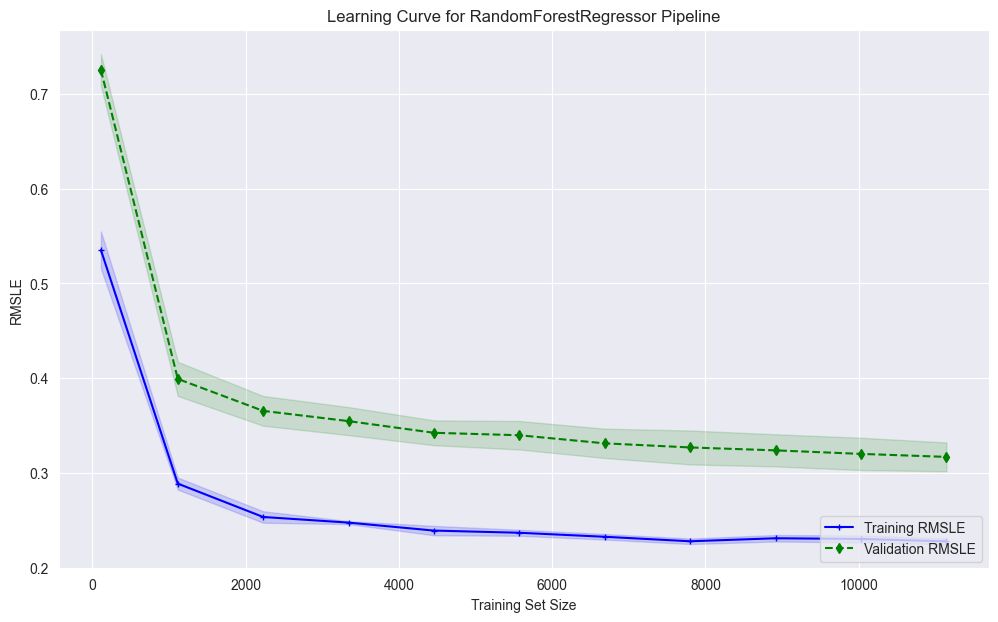

In [160]:
# Use the learning_curve function with the best_model_pipeline
train_sizes, train_scores, test_scores = learning_curve(
    estimator=optimized_model,
    X=X_train,
    y=y_train,
    train_sizes=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_log_error',
    shuffle=False  # set to True if you need to randomize the data splits
)

# Since the score is negative, multiply by -1 to get positive RMSLE values
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curves
plt.figure(figsize=(12, 7))
plt.plot(train_sizes, train_mean,
         color='blue', marker='+', markersize=5,
         label='Training RMSLE')
plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--', marker='d', markersize=5,
         label='Validation RMSLE')
plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.xlabel('Training Set Size')
plt.ylabel('RMSLE')
plt.title('Learning Curve for RandomForestRegressor Pipeline')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

As we can see with the increase in the test set size, the RMSLE decreasing indicating lower error as more data is available, which is logical because data helps model to learn in a better way. 

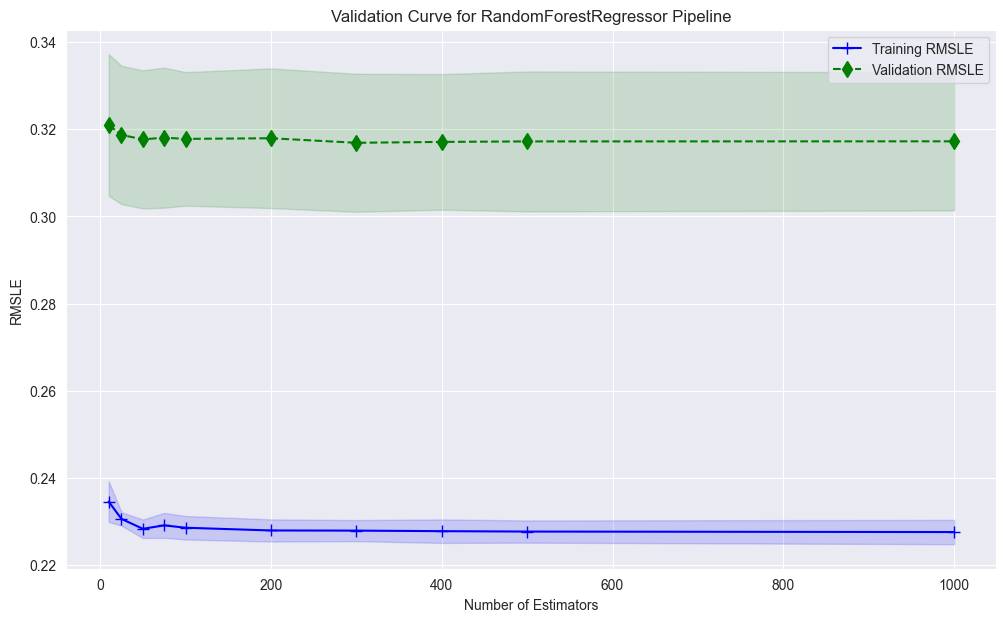

In [161]:
n_estimators_range = [10, 25, 50, 75, 100, 200, 300, 400, 500, 1000]
train_scores, test_scores = validation_curve(
    estimator=optimized_model,
    X=X_train,
    y=y_train,
    param_name='classifier__n_estimators',  # Change if your pipeline uses a different name
    param_range=n_estimators_range,
    cv=5,
    scoring='neg_root_mean_squared_log_error',
    n_jobs=-1
)

# Since the scoring is negative (because of the 'neg_root_mean_squared_log_error'),
# multiply by -1 to obtain positive RMSLE values.

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(12, 7))
plt.plot(n_estimators_range, train_mean,
         color='blue', marker='+', markersize=8,
         label='Training RMSLE')
plt.fill_between(n_estimators_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(n_estimators_range, test_mean,
         color='green', linestyle='--', marker='d', markersize=8,
         label='Validation RMSLE')
plt.fill_between(n_estimators_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.xlabel('Number of Estimators')
plt.ylabel('RMSLE')
plt.title('Validation Curve for RandomForestRegressor Pipeline')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Here we can see that the number of estimators is making the validation and training curves to fluctuate in between the values of 0 and 100, but then they follow almost constant measure of error. This means that it is better use n=100 or n=200, because it provides good results while not demanding a lot of resources for computation. 

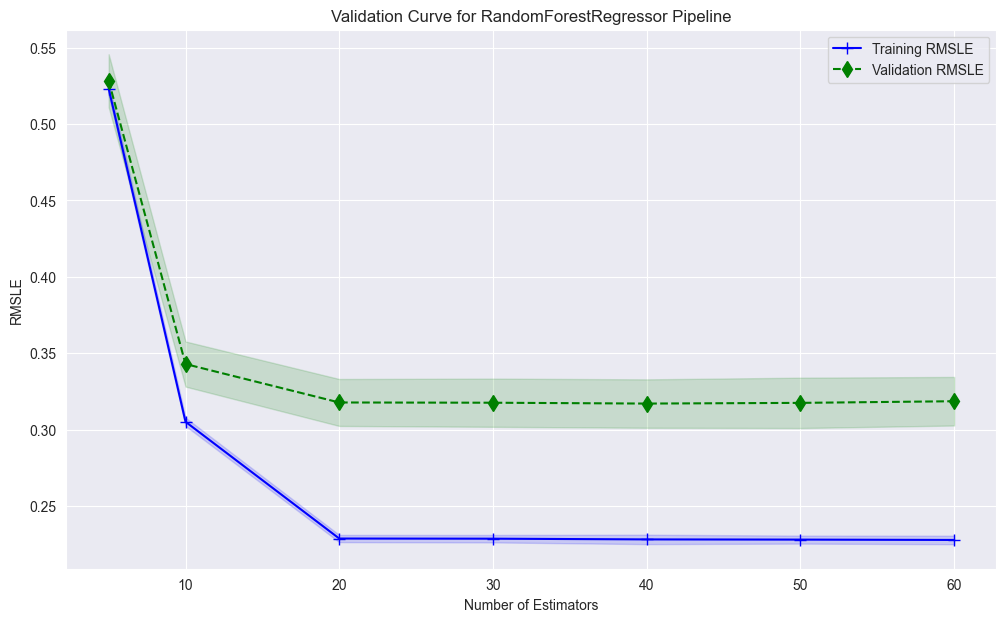

In [162]:
max_depth_range = [5, 10, 20, 30, 40 ,50, 60]
train_scores, test_scores = validation_curve(
    estimator=optimized_model,
    X=X_train,
    y=y_train,
    param_name='classifier__max_depth',  # Change if your pipeline uses a different name
    param_range=max_depth_range,
    cv=5,
    scoring='neg_root_mean_squared_log_error',
    n_jobs=-1
)

# Since the scoring is negative (because of the 'neg_root_mean_squared_log_error'),
# multiply by -1 to obtain positive RMSLE values.

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(12, 7))
plt.plot(max_depth_range, train_mean,
         color='blue', marker='+', markersize=8,
         label='Training RMSLE')
plt.fill_between(max_depth_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(max_depth_range, test_mean,
         color='green', linestyle='--', marker='d', markersize=8,
         label='Validation RMSLE')
plt.fill_between(max_depth_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.xlabel('Number of Estimators')
plt.ylabel('RMSLE')
plt.title('Validation Curve for RandomForestRegressor Pipeline')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


The error decrases with the increase in the number of estimators from 0 to 20, however after 20 there is almost no change in the error. So the value of estimators of 20 should be used because it provides the best trade-off between the resources needed for computation and the value of RMSLE. 

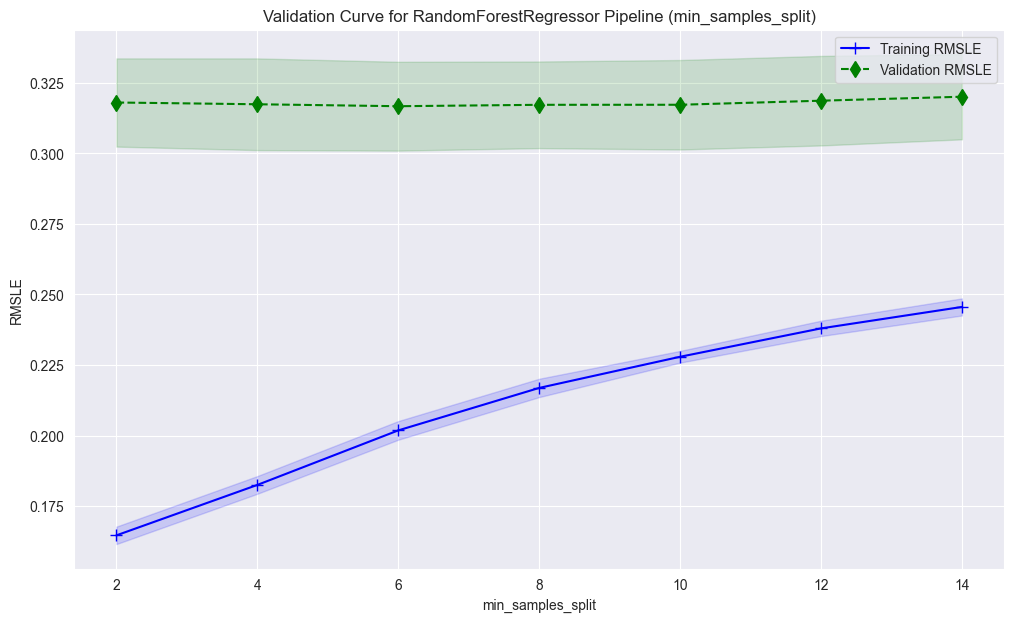

In [166]:
# Define the range for min_samples_split
min_samples_split_range = [2, 4, 6, 8, 10, 12, 14]

# Compute the validation curve
train_scores, test_scores = validation_curve(
    estimator=optimized_model,
    X=X_train,
    y=y_train,
    param_name='classifier__min_samples_split',  # Adjust if your pipeline uses a different name
    param_range=min_samples_split_range,
    cv=5,
    scoring='neg_root_mean_squared_log_error',
    n_jobs=-1
)

# Since the scoring is negative (due to 'neg_root_mean_squared_log_error'),
# multiply by -1 to get positive RMSLE values.
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(12, 7))
plt.plot(min_samples_split_range, train_mean,
         color='blue', marker='+', markersize=8,
         label='Training RMSLE')
plt.fill_between(min_samples_split_range,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(min_samples_split_range, test_mean,
         color='green', linestyle='--', marker='d', markersize=8,
         label='Validation RMSLE')
plt.fill_between(min_samples_split_range,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.xlabel('min_samples_split')
plt.ylabel('RMSLE')
plt.title('Validation Curve for RandomForestRegressor Pipeline (min_samples_split)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


Here, the min_samples_split is only affecting the training curve RMSLE, and the error is increasing with the increase in the min_samples_split, so the lowest values should be used. The increase in the value of the min_samples_split is supposed to create less complex trees and therefore reduce overfitting, however in this case, the simpler trees lead to higher errors, while the validation set is not changed. 